In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import time
import cv2

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

%matplotlib inline

In [2]:
#hdf_path = r'E:/ultimate/day1_streams/masks/df.hdf'
hdf_path = r'E:/ultimate/day1_streams/masks/df2.hdf'

df = pd.read_hdf(hdf_path)
df.head()

#
# Shuffle the rows to get a good spread on pixel samples.
#
df = df.sample(frac=1).reset_index(drop=True)

In [3]:
df.head()

hue  hue_east  hue_north  hue_south  hue_west  inmask  saturation  \
0  0.450980  0.450980   0.505882   0.450980  0.403922   False    0.305882   
1  0.615686  0.678431   0.580392   0.615686  0.615686   False    0.917647   
2  0.235294  0.035294   0.215686   0.180392  0.235294   False    0.019608   
3  0.101961  0.101961   0.098039   0.101961  0.098039   False    0.952941   
4  0.058824  0.086275   0.541176   0.058824  0.058824   False    0.952941   

   saturation_east  saturation_north  saturation_south  saturation_west  \
0         0.349020          0.356863          0.388235         0.305882   
1         0.772549          0.827451          0.901961         0.854902   
2         0.027451          0.023529          0.043137         0.011765   
3         0.945098          0.956863          0.952941         0.941176   
4         0.901961          0.866667          0.952941         0.917647   

      value  value_east  value_north  value_south  value_west  
0  0.078431    0.066667     0.231373     0.058824    0.231373  
1  0.137255    0.133333     0.133333     0.137255    0.145098  
2  1.000000    1.000000     1.000000     1.000000    1.000000  
3  0.521569    0.525490     0.494118     0.521569    0.521569  
4  0.196078    0.109804     0.054902     0.196078    0.203922

In [4]:
df['inmask_clean'] = np.where(df['inmask'] == True, 1.0, -1.0)
x_train, x_test = train_test_split(df, test_size=0.3, random_state=int(time.time()))

dt = DecisionTreeClassifier()
used_features = [
    'hue',
    'value',
    'saturation'
]

dt.fit(
    x_train[used_features].values,
    x_train['inmask_clean']
)

y_pred = dt.predict(x_test[used_features])

In [5]:
points = (x_test['inmask_clean'] != y_pred).sum()
print('Number of mislabeled points out of a total {} points: {}'.format(
    x_test.shape[0],
    points
))

Number of mislabeled points out of a total 1617796 points: 28917


In [6]:
print('Performance = {:05.2f}%'.format(100 * (1.0 - float(points) / x_test.shape[0])))

Performance = 98.21%


Huh. That doesn't seem right...

In [7]:
def test_and_plot_image(imgpath, model):
    img = cv2.cvtColor(cv2.imread(imgpath), cv2.COLOR_BGR2RGB)
    
    n = 5
    hues        = [[] for _ in range(n)]
    values      = [[] for _ in range(n)]
    saturations = [[] for _ in range(n)]
    
    hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV) / 255.0
    channels = cv2.split(hsv_img)

    for i, c in enumerate(channels):
        to_extend = [hues, values, saturations][i]

        c = np.pad(c, pad_width=1, mode='edge')
        channel_shifts = [
            c[1:-1,1:-1],
            np.roll(c,  1, axis=0)[1:-1,1:-1], # north
            np.roll(c, -1, axis=1)[1:-1,1:-1], # east
            np.roll(c, -1, axis=0)[1:-1,1:-1], # south
            np.roll(c,  1, axis=1)[1:-1,1:-1]  # west
            ]

        for j, shift in enumerate(channel_shifts):
            to_extend[j].extend(shift.reshape(-1))
    
    temp_df = pd.DataFrame({
        'hue'              : hues[0],
        'value'            : values[0],
        'saturation'       : saturations[0],

        #'hue_north'        : hues[1],
        #'value_north'      : values[1],
        #'saturation_north' : saturations[1],

        #'hue_east'         : hues[2],
        #'value_east'       : values[2],
        #'saturation_east'  : saturations[2],

        #'hue_south'        : hues[3],
        #'value_south'      : values[3],
        #'saturation_south' : saturations[3],

        #'hue_west'         : hues[4],
        #'value_west'       : values[4],
        #'saturation_west'  : saturations[4],
    })
 
    pred_mask = np.where(model.predict(temp_df) > 0, 255, 0)
    pred_img = pred_mask.reshape(hsv_img.shape[0], hsv_img.shape[1])
    
    _, ax = plt.subplots(1, 2)
    ax[0].imshow(img)
    ax[1].imshow(pred_img)

In [8]:
test_image_path = 'E:/Ultimate/day1_streams/masks/102_58.1.png'
image_mask_dir = 'E:/Ultimate/day1_streams/masks'

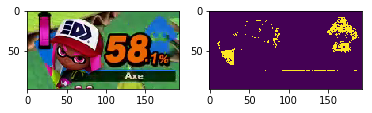

In [9]:
# TODO: Measure perf
test_and_plot_image(test_image_path, dt)

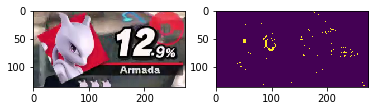

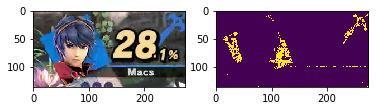

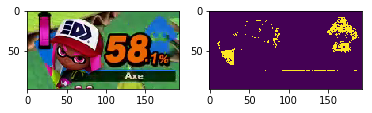

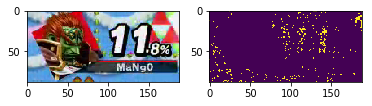

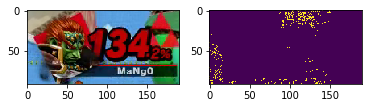

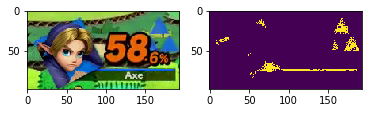

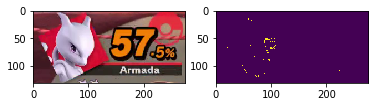

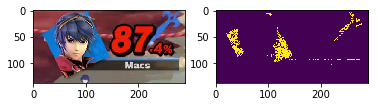

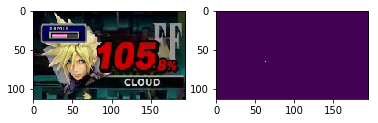

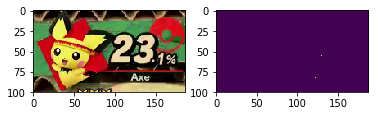

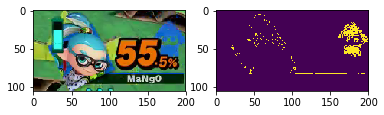

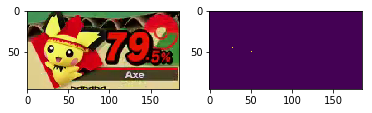

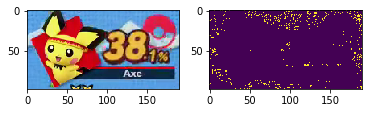

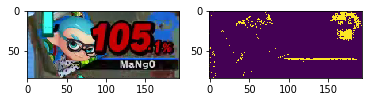

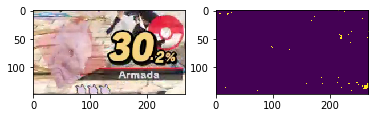

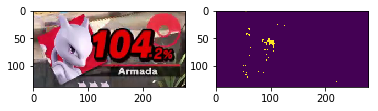

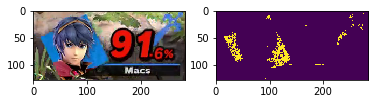

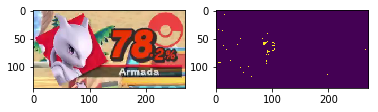

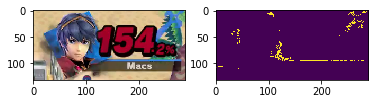

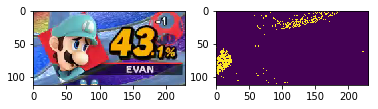

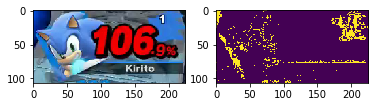

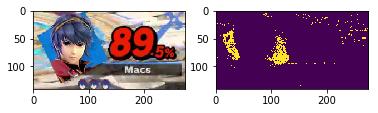

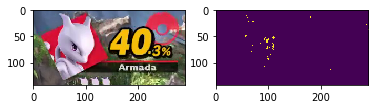

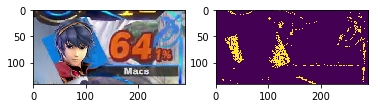

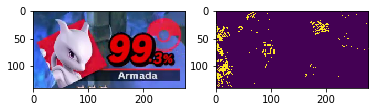

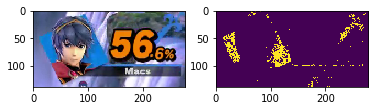

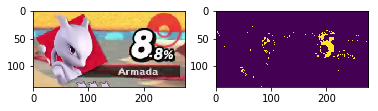

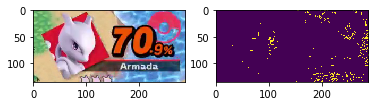

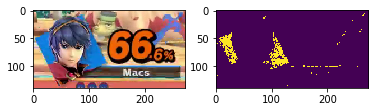

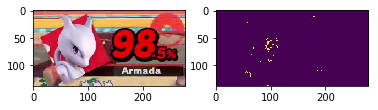

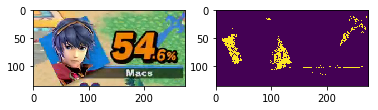

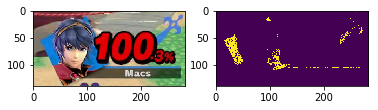

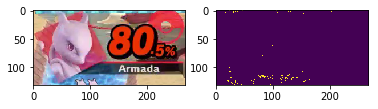

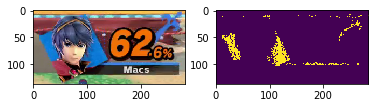

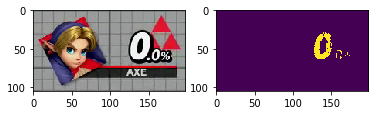

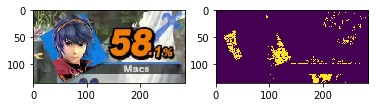

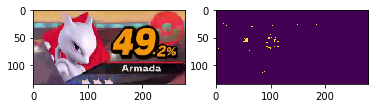

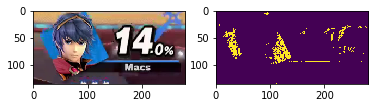

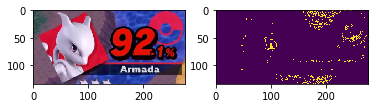

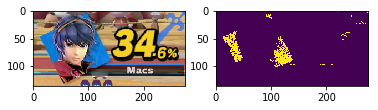

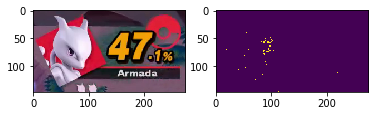

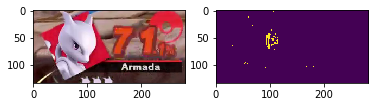

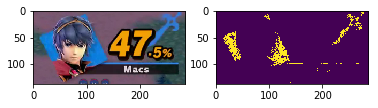

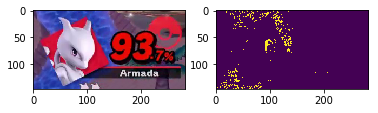

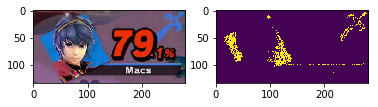

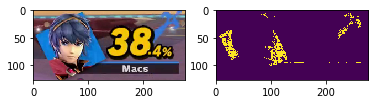

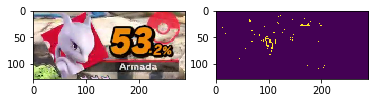

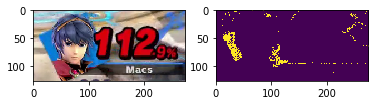

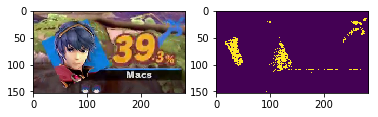

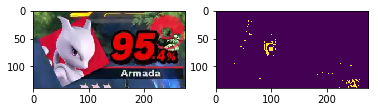

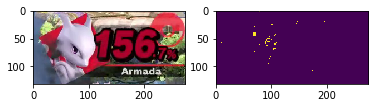

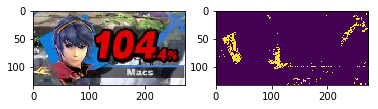

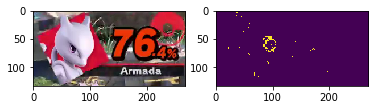

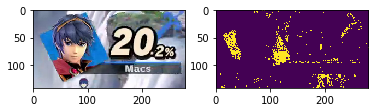

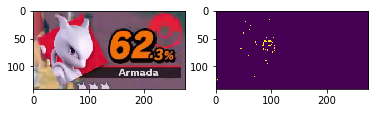

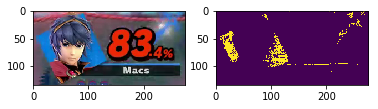

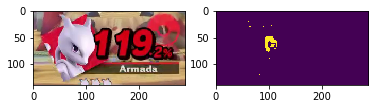

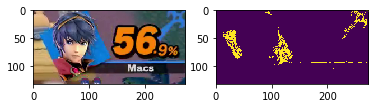

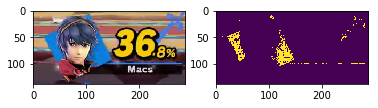

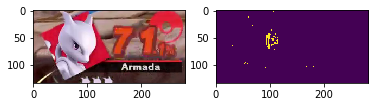

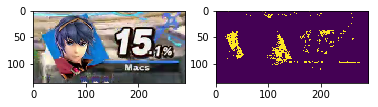

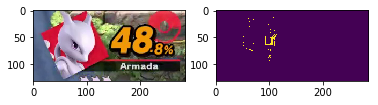

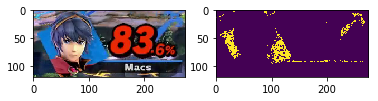

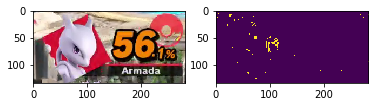

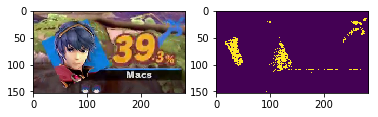

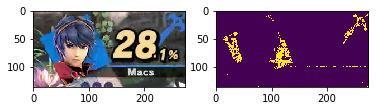

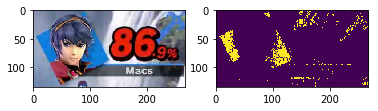

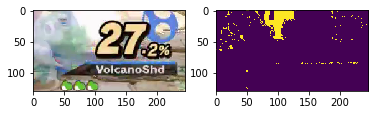

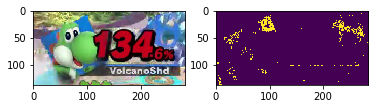

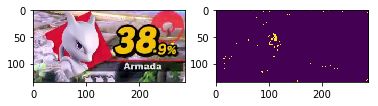

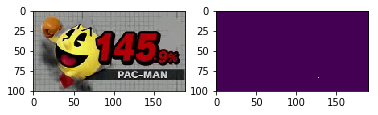

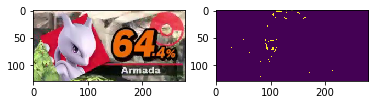

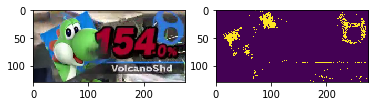

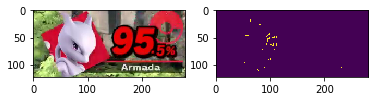

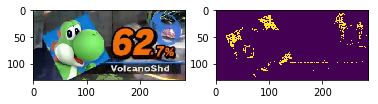

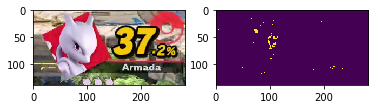

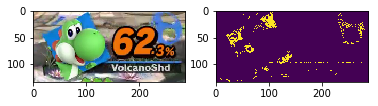

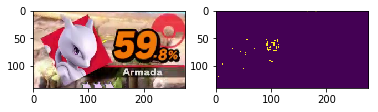

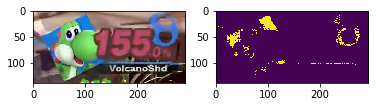

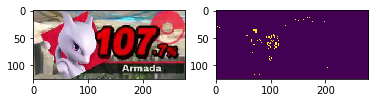

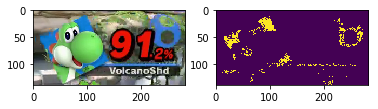

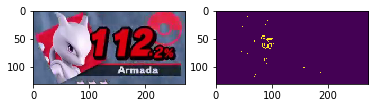

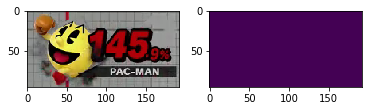

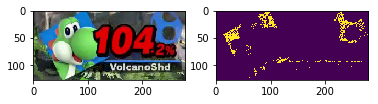

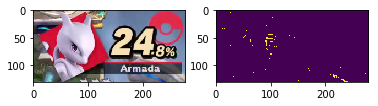

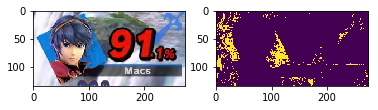

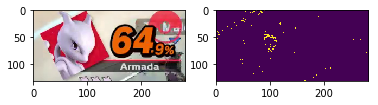

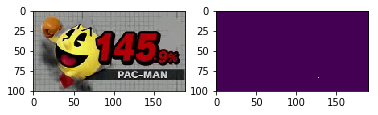

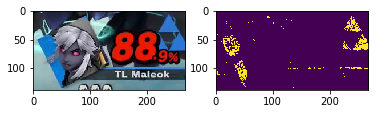

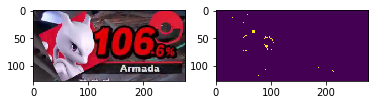

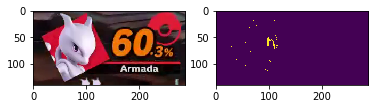

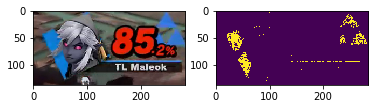

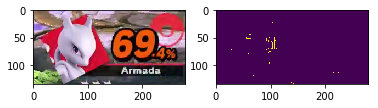

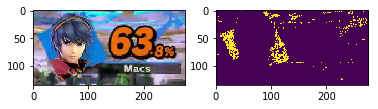

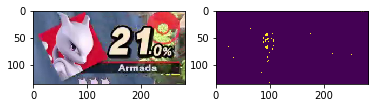

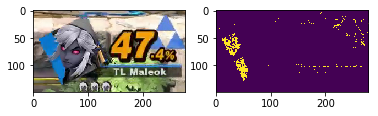

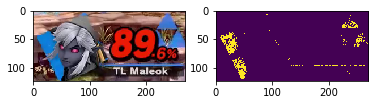

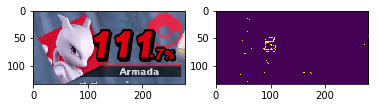

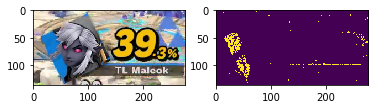

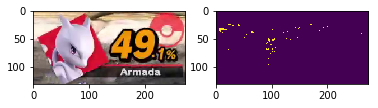

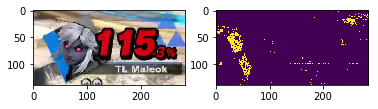

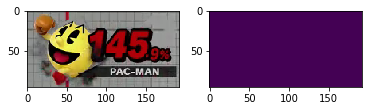

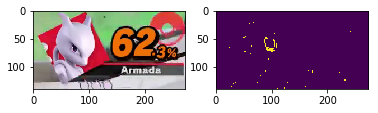

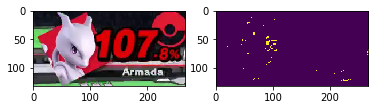

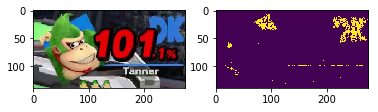

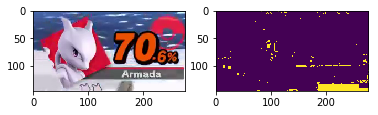

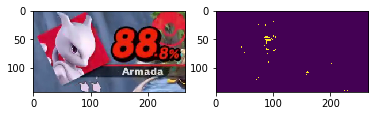

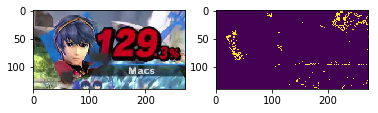

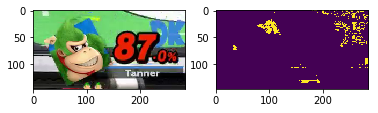

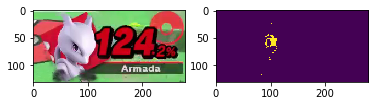

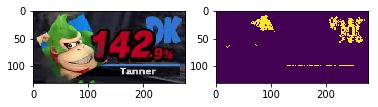

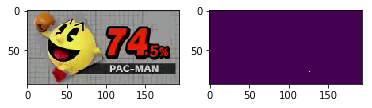

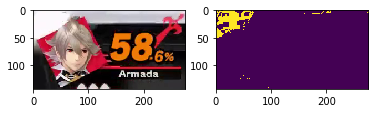

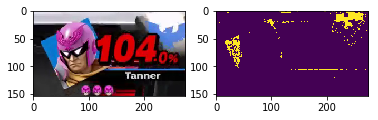

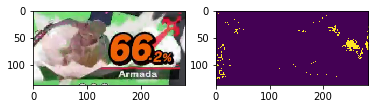

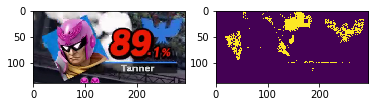

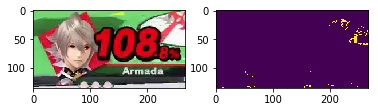

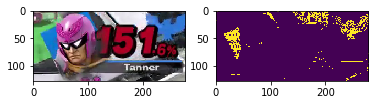

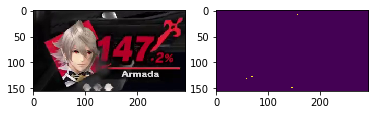

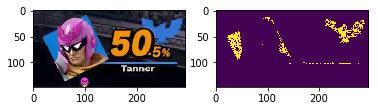

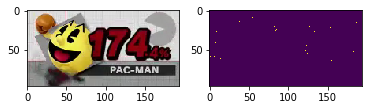

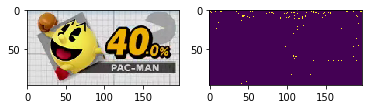

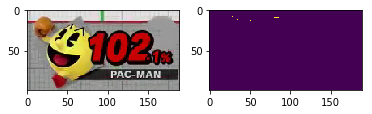

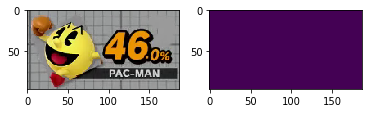

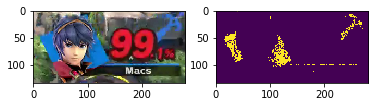

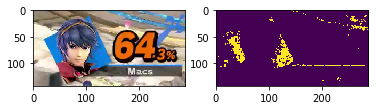

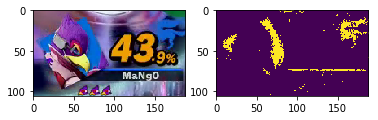

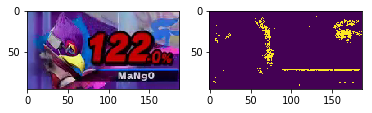

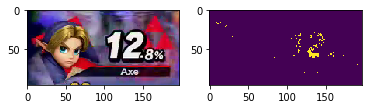

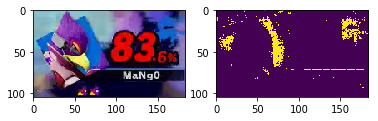

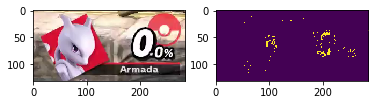

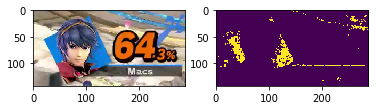

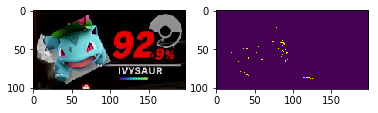

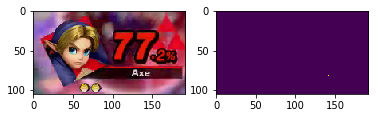

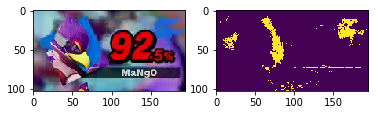

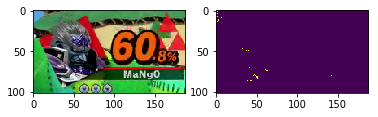

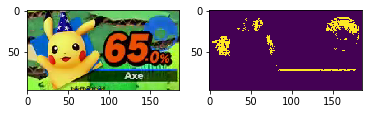

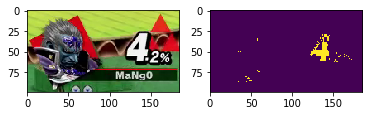

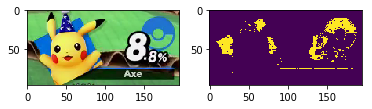

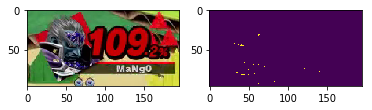

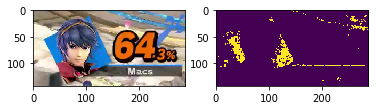

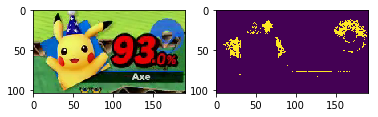

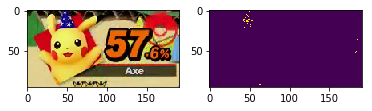

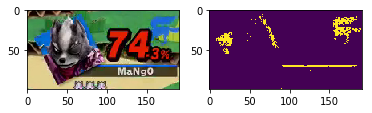

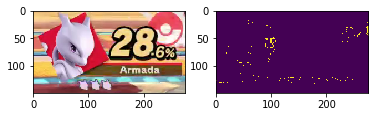

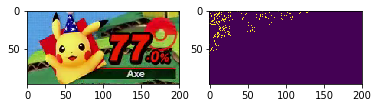

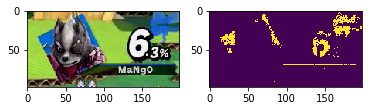

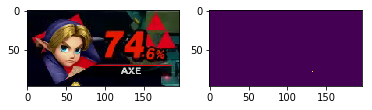

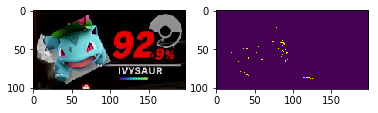

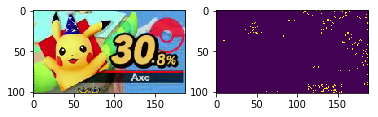

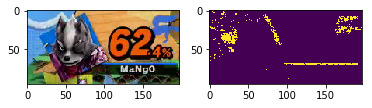

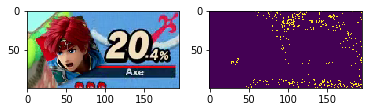

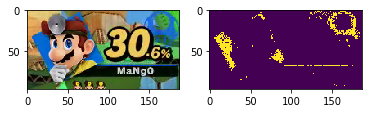

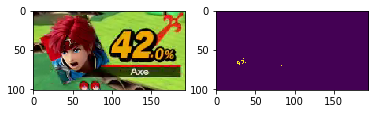

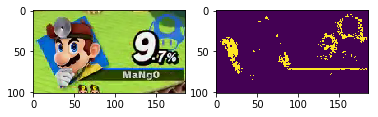

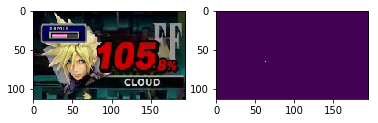

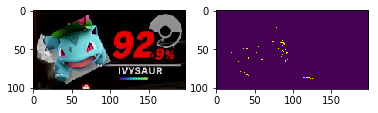

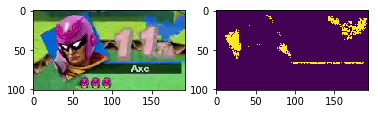

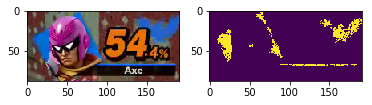

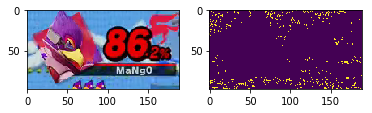

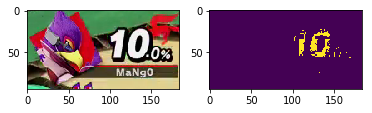

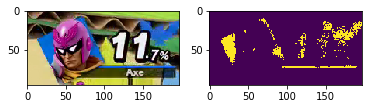

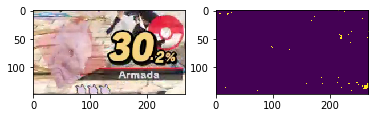

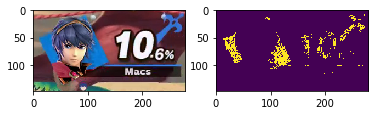

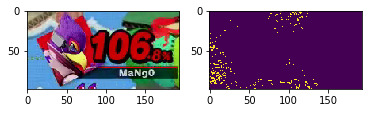

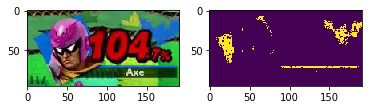

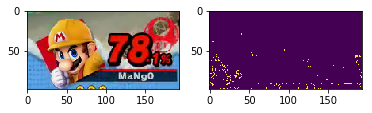

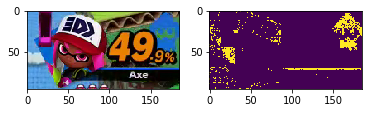

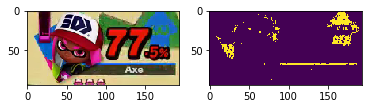

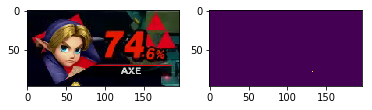

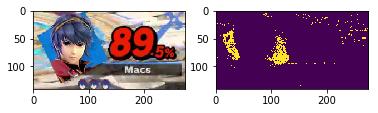

In [10]:
performance = []
for imgfile in [f for f in os.listdir(image_mask_dir) if f[-4:] == ".png" and not "mask" in f]:
    imgpath = os.path.join(image_mask_dir, imgfile)
    test_and_plot_image(imgpath, dt)
    
    #
    # Too many figures, gotta undermine matplotlib's inline plotting to save
    # ram and eliminate some really verbose and annoying warnings.
    #
    plt.show()
    plt.close('all')